In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import env

from datetime import date

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Acquire

##### function that accesses db server and querries logs and cohorts tables from the curriculm_logs db.

In [2]:
#db access
def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

#curriculum_logs db
log_sql = "SELECT *\
              FROM logs\
              LEFT JOIN cohorts ON logs.cohort_id = cohorts.id;"

##### grabs dataset from get_connection function above and formats it into a pandas dataframe.

In [3]:
#acquires curriculum_logs dataset
def get_log_data():
    return pd.read_sql(log_sql,get_connection('curriculum_logs'))

##### sets the queried datframe as 'df'.

In [4]:
df = get_log_data()
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0


##### create a dictionary with the class types to append to the df by 'program id'.

In [5]:
class_type_dict = {'id':[1, 2, 3, 4],
        'Name':['PHP Full Stack Web Development', 
                'Java Full Stack Web Development', 
                'Data Science', 
                'Front End Web Development'],
        'subdomain':['php','java','ds','fe']}
class_type = pd.DataFrame(class_type_dict)
print (class_type)

   id                             Name subdomain
0   1   PHP Full Stack Web Development       php
1   2  Java Full Stack Web Development      java
2   3                     Data Science        ds
3   4        Front End Web Development        fe


##### merges df and class_type datasets

In [6]:
df = df.merge(class_type, how='left', left_on='program_id', right_on='id')

In [7]:
df.head()

,date,time,path,user_id,cohort_id,ip,id_x,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,id_y,Name,subdomain
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,2.0,Java Full Stack Web Development,java


##### caches dataset for accessibility.

In [8]:
df.to_csv('/Users/hector/codeup-data-science/anomaly-detection-project/log_data.csv')

# Prepare

##### bring in logs dataframe for prep

In [9]:
df.head()

,date,time,path,user_id,cohort_id,ip,id_x,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id,id_y,Name,subdomain
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8.0,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1.0,1.0,PHP Full Stack Web Development,php
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22.0,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,None,2.0,2.0,Java Full Stack Web Development,java


In [10]:
df.shape

(900223, 18)

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,900223.0,458.825707,249.296767,1.0,269.0,475.0,660.0,981.0
cohort_id,847330.0,48.501049,32.795482,1.0,28.0,33.0,57.0,139.0
id_x,847330.0,48.501049,32.795482,1.0,28.0,33.0,57.0,139.0
program_id,847330.0,2.086004,0.388231,1.0,2.0,2.0,2.0,4.0
id_y,847330.0,2.086004,0.388231,1.0,2.0,2.0,2.0,4.0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id_x        847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       object 
 14  program_id  847330 non-null  float64
 15  id_y        847330 non-null  float64
 16  Name        847330 non-null  object 
 17  subdomain   847330 non-null  object 
dtypes: float64(4), int64(1), object(13)
memory u

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900223 entries, 0 to 900222
Data columns (total 18 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        900223 non-null  object 
 1   time        900223 non-null  object 
 2   path        900222 non-null  object 
 3   user_id     900223 non-null  int64  
 4   cohort_id   847330 non-null  float64
 5   ip          900223 non-null  object 
 6   id_x        847330 non-null  float64
 7   name        847330 non-null  object 
 8   slack       847330 non-null  object 
 9   start_date  847330 non-null  object 
 10  end_date    847330 non-null  object 
 11  created_at  847330 non-null  object 
 12  updated_at  847330 non-null  object 
 13  deleted_at  0 non-null       object 
 14  program_id  847330 non-null  float64
 15  id_y        847330 non-null  float64
 16  Name        847330 non-null  object 
 17  subdomain   847330 non-null  object 
dtypes: float64(4), int64(1), object(13)
memory u

In [14]:
#splits the path into two colums, I will keep 'path_2' and drop 'path'
df['path_2'] = df.path.str.split('/').str[1]

In [15]:
#Found empty string values in path_2. This code replaces the empty cells with 'NaN'
#in order to drop nulls later.
df['path_2'].replace('', np.nan, inplace=True)

In [16]:
#merge date and time columns
df['date'] = df['date'] +' '+ df['time']#concat time and date

In [17]:
#datetime conversion and set index   
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

In [18]:
#drop columns. these columns have no use.
df = df.drop(columns=['time', 'id_x', 'slack', 'id_y', 'Name', 'deleted_at', 'path'])

In [19]:
#rename columns
df = df.rename(columns = {'name':'cohort', 'start_date':'class_start_date', 'end_date':'class_end_date'})    

In [20]:
df.isnull().sum()

user_id                  0
cohort_id            52893
ip                       0
cohort               52893
class_start_date     52893
class_end_date       52893
created_at           52893
updated_at           52893
program_id           52893
subdomain            52893
path_2              218665
dtype: int64

In [21]:
#drops nulls (rows)
df = df.dropna()

In [22]:
df.isnull().sum()

user_id             0
cohort_id           0
ip                  0
cohort              0
class_start_date    0
class_end_date      0
created_at          0
updated_at          0
program_id          0
subdomain           0
path_2              0
dtype: int64

In [23]:
#converts dtypes for listed features
convert_dict_int = {'cohort_id':int, 'program_id':int, 'class_start_date':'datetime64[ns]', 'class_end_date':'datetime64[ns]', 'created_at':'datetime64[ns]', 'updated_at':'datetime64[ns]'}
df = df.astype(convert_dict_int)

In [24]:
df.head()

,user_id,cohort_id,ip,cohort,class_start_date,class_end_date,created_at,updated_at,program_id,subdomain,path_2
date,,,,,,,,,,,
2018-01-26 09:56:05,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,php,object-oriented-programming
2018-01-26 09:56:06,1,8,97.105.19.61,Hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,1,php,object_oriented_programming
2018-01-26 09:56:24,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,conditionals
2018-01-26 09:56:41,2,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,loops
2018-01-26 09:56:46,3,22,97.105.19.61,Teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,2,java,conditionals


In [25]:
df.to_csv('/Users/hector/codeup-data-science/anomaly-detection-project/log_clean.csv')

In [26]:
df.user_id.value_counts().head()

11     13862
64     11328
53      8110
581     5990
314     5835
Name: user_id, dtype: int64

In [34]:
df.cohort_id.value_counts().head()

28    59767
33    31670
59    28821
29    28382
53    27505
Name: cohort_id, dtype: int64

In [30]:
df.ip.value_counts().head()

97.105.19.58       212185
97.105.19.61        48390
192.171.117.210      6853
71.150.217.33        4418
76.185.145.231       4285
Name: ip, dtype: int64

In [77]:
df.ip.value_counts(normalize=True).head()

97.105.19.58       0.323510
97.105.19.61       0.073778
192.171.117.210    0.010448
71.150.217.33      0.006736
76.185.145.231     0.006533
Name: ip, dtype: float64

In [78]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

In [79]:
ip_df = value_counts_and_frequencies(df.ip)
ip_df.head()

,count,proba
97.105.19.58,212185,0.323510
97.105.19.61,48390,0.073778
192.171.117.210,6853,0.010448
71.150.217.33,4418,0.006736
76.185.145.231,4285,0.006533


<AxesSubplot:>

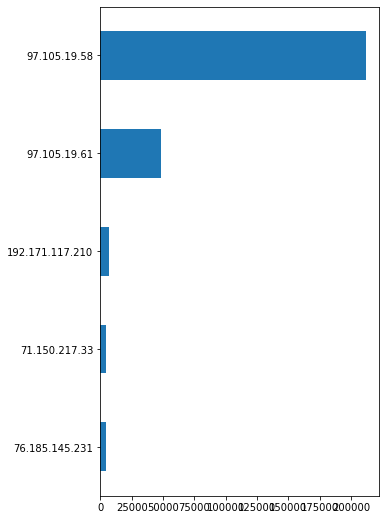

In [124]:
ip_df['count'].sort_values().tail().plot.barh(figsize=(5, 9))

In [31]:
df.program_id.value_counts().head()

2    538442
3     94478
1     22960
4         4
Name: program_id, dtype: int64

# Explore

1. Discrete data is a numerical type of data that includes whole, concrete numbers with specific and fixed data values determined by counting. 
        - disconnected, separate, and distinct
        - to find relationships, trends, and other concepts
        - In many cases, discrete data can be prefixed with “the number of.”
        - whole, round number that can't be broken down into smaller parts.
        - Discrete data includes discrete variables that are finite, numeric, countable, and non-negative integers (5, 10, 15, and so on).
        - can also be categorical - contain a finite number of data values, such as the gender of a person.
        - Discrete data is distributed discretely in terms of time and space.

2. Continuous data includes complex numbers and varying data values that are measured over a specific time interval.-- refers to change over time
        - unspecified number of possible measurements between two realistic points.
        - all about accuracy
        - data sets often carry decimal points
        - The weight of newborn babies
        - The daily wind speed
        - The temperature of a freezer
        - clocking every runner in the Olympics
        - There are infinite possibilities along this line (for example, 5.77 seconds, 5.772 seconds, 5.7699 seconds, etc.), but every new measurement is always somewhere within the range.
        - continuous data can be either numeric or distributed over date and time.
        - changes over time and can have different values at different time intervals.
        - random variables, which may or may not be whole numbers.
        - Regression analysis is one of the most common types of continuous data analysis.

1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

- which lesson appears the most across cohorts?
- groupby cohort and get a count of lessons (max)...maybe?

In [134]:
lesson_across_cohorts = (df.sort_values('cohort').path_2.value_counts(normalize=True).rename('cohort_count').reset_index())
lesson_across_cohorts.head()

,index,cohort_count
0,introduction,0.057044
1,fundamentals,0.052464
2,css-i,0.048164
3,css-ii,0.030890
4,search_index.json,0.029578


In [132]:
lesson_across_cohorts.to_csv('/Users/hector/codeup-data-science/anomaly-detection-project/lesson_across_cohorts.csv')

2. Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?
- Opposite of the above (min)
_ graph all cohortsand show 

In [135]:
cohorts_to_lesson= (df.sort_values('path_2').cohort.value_counts().rename('path_count').reset_index())
cohorts_to_lesson.head()

,index,path_count
0,Staff,59767
1,Ceres,31670
2,Darden,28821
3,Zion,28382
4,Fortuna,27505


In [136]:
cohorts_to_lesson.to_csv('/Users/hector/codeup-data-science/anomaly-detection-project/cohorts_to_lesson.csv')

3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

- student, active, that do not access the curriculum  (ip address ?)

In [138]:
student_activity = (df.sort_values('ip').user_id.value_counts().rename('ip_count').reset_index())
student_activity.head()

,index,ip_count
0,11,13862
1,64,11328
2,53,8110
3,581,5990
4,314,5835


In [139]:
student_activity.to_csv('/Users/hector/codeup-data-science/anomaly-detection-project/student_activity.csv')

4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?



In [71]:
status_given_ip = (
    df.groupby('ip')
    ..value_counts(normalize=True)
    .rename('proba_uid_given_ip')
    .reset_index()
)
status_given_ip.head()

,ip,program_id,proba_uid_given_ip
0,100.11.170.135,2,1.0
1,100.19.73.35,2,1.0
2,100.35.67.162,2,1.0
3,103.137.12.164,3,1.0
4,104.1.46.153,2,1.0


5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?



6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

7. Which lessons are least accessed?

In [84]:
lesson = (df.sort_values('path_2').ip.value_counts().rename('p2_count').reset_index())
lesson.tail(25)

,index,p2_count
4784,173.123.79.79,1
4785,64.9.239.9,1
4786,208.116.188.250,1
4787,24.28.154.168,1
4788,172.56.7.87,1
4789,70.121.216.135,1
4790,136.50.24.156,1
4791,173.127.7.219,1
4792,99.98.245.245,1
4793,172.58.99.22,1


8. Anything else I should be aware of?

In [86]:
pages = df['path_2'].resample('W').count()
pages.head()

date
2018-01-28     709
2018-02-04    3115
2018-02-11    2310
2018-02-18    2226
2018-02-25    2381
Freq: W-SUN, Name: path_2, dtype: int64

<AxesSubplot:xlabel='date'>

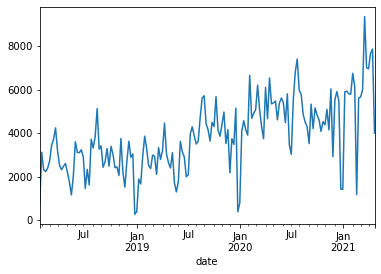

In [87]:
pages.plot()

In [88]:
# 7 day EMA
ema_7d = pages.ewm(span=7).mean()
ema_7d.head()

date
2018-01-28     709.000000
2018-02-04    2083.857143
2018-02-11    2181.648649
2018-02-18    2197.868571
2018-02-25    2257.896287
Freq: W-SUN, Name: path_2, dtype: float64

In [89]:
# 14 days EMA
ema_14d = pages.ewm(span=14).mean()
ema_14d.head()

date
2018-01-28     709.000000
2018-02-04    1997.928571
2018-02-11    2117.140917
2018-02-18    2150.443981
2018-02-25    2210.595694
Freq: W-SUN, Name: path_2, dtype: float64

In [90]:
# 30 days EMA
ema_30d = pages.ewm(span=30).mean()
ema_30d.head()

date
2018-01-28     709.000000
2018-02-04    1952.100000
2018-02-11    2079.438726
2018-02-18    2119.821698
2018-02-25    2179.246085
Freq: W-SUN, Name: path_2, dtype: float64

In [91]:
# 90 days EMA
ema_90d = pages.ewm(span=90).mean()
ema_90d.head()

date
2018-01-28     709.000000
2018-02-04    1925.366667
2018-02-11    2056.437348
2018-02-18    2100.251383
2018-02-25    2158.924063
Freq: W-SUN, Name: path_2, dtype: float64

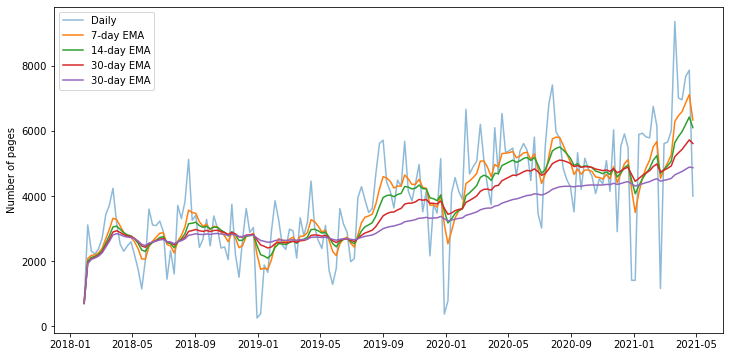

In [92]:
fig, ax = plt.subplots(figsize=(12,6))

ax.plot(pages.index, pages, label='Daily', alpha=.5)

ax.plot(pages.index, ema_7d, label = '7-day EMA')
ax.plot(pages.index, ema_14d, label = '14-day EMA')
ax.plot(pages.index, ema_30d, label = '30-day EMA')
ax.plot(pages.index, ema_90d, label = '30-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()


# Bollinger Bands and %b

In [94]:
# set the window span
span = 30

# compute midband
midband = pages.ewm(span=span).mean()

midband.head()

date
2018-01-28     709.000000
2018-02-04    1952.100000
2018-02-11    2079.438726
2018-02-18    2119.821698
2018-02-25    2179.246085
Freq: W-SUN, Name: path_2, dtype: float64

In [95]:
# compute exponential stdev
stdev = pages.ewm(span=span).std()

stdev.head()


date
2018-01-28            NaN
2018-02-04    1701.298916
2018-02-11    1201.279769
2018-02-18     967.142068
2018-02-25     832.259982
Freq: W-SUN, Name: path_2, dtype: float64

In [96]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3
ub

date
2018-01-28             NaN
2018-02-04     7055.996747
2018-02-11     5683.278034
2018-02-18     5021.247903
2018-02-25     4676.026030
                  ...     
2021-03-28    11020.140913
2021-04-04    11072.086082
2021-04-11    11282.781939
2021-04-18    11502.655736
2021-04-25    11349.516436
Freq: W-SUN, Name: path_2, Length: 170, dtype: float64

In [97]:
lb

date
2018-01-28            NaN
2018-02-04   -3151.796747
2018-02-11   -1524.400581
2018-02-18    -781.604507
2018-02-25    -317.533859
                 ...     
2021-03-28    -368.942751
2021-04-04    -210.768613
2021-04-11    -133.029411
2021-04-18     -58.044776
2021-04-25    -127.657225
Freq: W-SUN, Name: path_2, Length: 170, dtype: float64

In [98]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']
bb.head()

,ub,lb
date,,
2018-01-28,NaN,NaN
2018-02-04,7055.996747,-3151.796747
2018-02-11,5683.278034,-1524.400581
2018-02-18,5021.247903,-781.604507
2018-02-25,4676.026030,-317.533859


In [99]:
my_df = pd.concat([pages, midband, bb], axis=1)
my_df.columns = ['pages', 'midband', 'ub', 'lb']
my_df.head()

,pages,midband,ub,lb
date,,,,
2018-01-28,709,709.000000,NaN,NaN
2018-02-04,3115,1952.100000,7055.996747,-3151.796747
2018-02-11,2310,2079.438726,5683.278034,-1524.400581
2018-02-18,2226,2119.821698,5021.247903,-781.604507
2018-02-25,2381,2179.246085,4676.026030,-317.533859


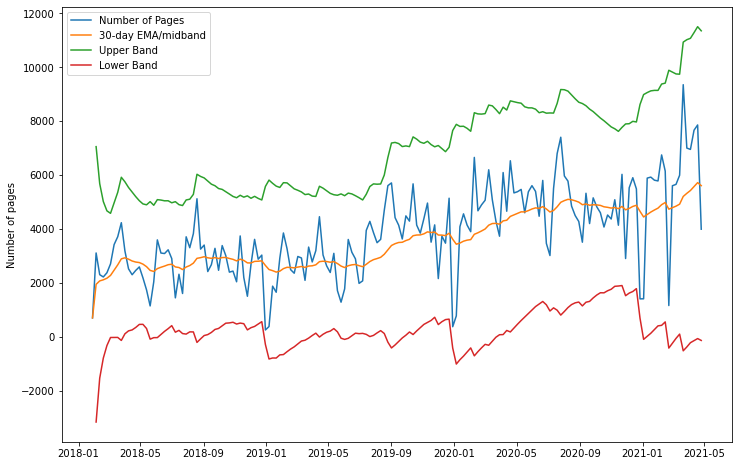

In [100]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.pages, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

In [101]:
# get the last measure of gb
last_measure = my_df.iloc[-1].pages
last_measure


3996.0

In [102]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb
last_lb

-127.65722548972826

In [103]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub
last_ub

11349.516436187972

In [104]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.36


In [105]:
my_df.tail(3)

,pages,midband,ub,lb
date,,,,
2021-04-11,7666,5574.876264,11282.781939,-133.029411
2021-04-18,7860,5722.305480,11502.655736,-58.044776
2021-04-25,3996,5610.929605,11349.516436,-127.657225


In [106]:
my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()


,pages,midband,ub,lb,pct_b
date,,,,,
2018-01-28,709,709.000000,NaN,NaN,NaN
2018-02-04,3115,1952.100000,7055.996747,-3151.796747,0.613923
2018-02-11,2310,2079.438726,5683.278034,-1524.400581,0.531988
2018-02-18,2226,2119.821698,5021.247903,-781.604507,0.518298
2018-02-25,2381,2179.246085,4676.026030,-317.533859,0.540403


In [107]:
my_df[my_df['pct_b']>1]

,pages,midband,ub,lb,pct_b
date,,,,,


In [108]:
def compute_pct_b(pages, span, weight, user):
    midband = pages.ewm(span=span).mean()
    stdev = pages.ewm(span=span).std()
    ub = midband + stdev*weight
    lb = midband - stdev*weight
    bb = pd.concat([ub, lb], axis=1)
    my_df = pd.concat([pages, midband, bb], axis=1)
    my_df.columns = ['pages', 'midband', 'ub', 'lb']
    my_df['pct_b'] = (my_df['pages'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])
    my_df['user_id'] = user
    return my_df

def plt_bands(my_df, user):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.plot(my_df.index, my_df.pages, label='Number of Pages, User: '+str(user))
    ax.plot(my_df.index, my_df.midband, label = 'EMA/midband')
    ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
    ax.plot(my_df.index, my_df.lb, label = 'Lower Band')
    ax.legend(loc='best')
    ax.set_ylabel('Number of Pages')
    plt.show()

def find_anomalies(df, user, span, weight):
    pages = prep(df, user)
    my_df = compute_pct_b(pages, span, weight, user)
    # plt_bands(my_df, user)
    return my_df[my_df.pct_b>1]

In [109]:
user = 1
span = 30
weight = 6
user_df = find_anomalies(df, user, span, weight)

anomalies = pd.DataFrame()
user_df = find_anomalies(df, user, span, weight)
anomalies = pd.concat([anomalies, user_df], axis=0)

NameError: name 'prep' is not defined